<a href="https://colab.research.google.com/github/FranciscoAguiar/DataScienceProgramming/blob/master/AtividadeSVM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns

## Example: Face Recognition

Como um exemplo de máquinas de vetores de suporte em ação, vamos dar uma olhada no problema de reconhecimento facial.

Usaremos o conjunto de dados Labeled Faces in the Wild, que consiste em vários milhares de fotos agrupadas de várias figuras públicas.

Um buscador para o conjunto de dados é integrado ao Scikit-Learn:

In [2]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person = 60)

print(faces.target_names)
print(faces.target)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
[1 3 3 ... 7 3 5]
(1348, 62, 47)


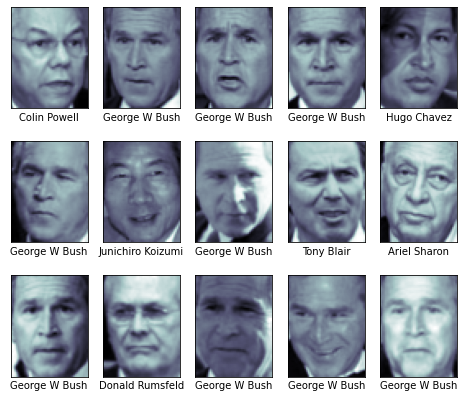

In [3]:
fig, ax = plt.subplots(3, 5,figsize=(8,7))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Cada imagem contém [62×47] ou quase 3.000 pixels.

O dataset já possui as imagens vetorizadas:


In [4]:
print(faces.data.shape)

(1348, 2914)


Poderíamos prosseguir simplesmente usando cada valor de pixel como um atributo, mas geralmente é mais eficaz usar algum tipo de pré-processador para extrair recursos mais significativos; aqui, usaremos uma análise de componente principal (PCA) para extrair 150 componentes fundamentais para alimentar nosso classificador de máquina de vetor de suporte.

Podemos fazer isso de maneira mais direta, empacotando o pré-processador e o classificador em um único pipeline:

In [5]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components = 150, whiten='True', random_state=42)

svc = SVC(kernel='rbf')

model = make_pipeline(pca, svc)

PCA permite reduzir a dimensão dos vetores, por exemplo passar de 2914 colunas para 15 colunas

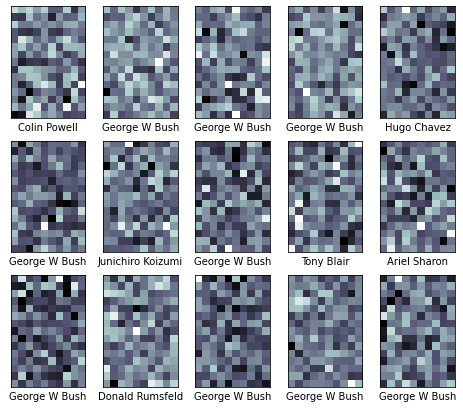

In [6]:
X_pca = pca.fit_transform(faces.data)

X_pca = X_pca.reshape(1348, 15, 10)

fig, ax = plt.subplots(3, 5,figsize=(8,7))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_pca[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Separando uma parte dos dados para teste

In [7]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

Aplicamos grid search com cross-validation para testar diferentes combinações dos parâmetros C e Gamma:

In [8]:
from sklearn.model_selection import GridSearchCV

# fine tuning

# param_grid = {'svc__C': [1, 5, 10, 50],
#               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}


param_grid = {'svc__C': [9.8, 10, 10.2],
              'svc__gamma': [0.0009, 0.001, 0.0011]}


grid = GridSearchCV(model, param_grid, cv=5)

%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: user 37 s, sys: 22.6 s, total: 59.6 s
Wall time: 34.4 s
{'svc__C': 10.2, 'svc__gamma': 0.0009}


Os valores ótimos dos parametros são:

In [9]:
model_best = grid.best_estimator_
print(model_best)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=150,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten='True')),
                ('svc',
                 SVC(C=10.2, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.0009,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


Predições com o módelo que tem os melhores parâmetros:

In [10]:
y_pred = model_best.predict(Xtest)

Mostrar alguns resultados



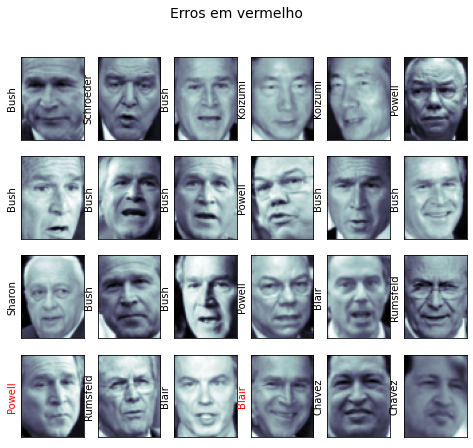

In [11]:
fig, ax = plt.subplots(4, 6, figsize=(8,7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == ytest[i] else 'red')
    
fig.suptitle('Erros em vermelho', size=14);

Classification report:

In [12]:
from sklearn.metrics import classification_report

print(classification_report(ytest, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.67      0.69        15
     Colin Powell       0.81      0.87      0.84        68
  Donald Rumsfeld       0.82      0.74      0.78        31
    George W Bush       0.88      0.87      0.88       126
Gerhard Schroeder       0.75      0.78      0.77        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      0.92      0.92        12
       Tony Blair       0.87      0.95      0.91        42

         accuracy                           0.85       337
        macro avg       0.84      0.81      0.82       337
     weighted avg       0.85      0.85      0.84       337



Matriz de confusão

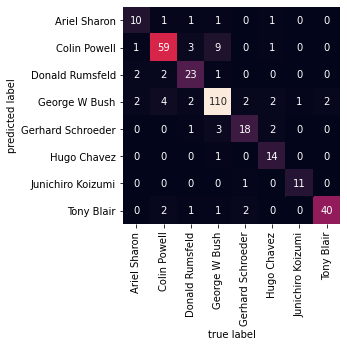

In [13]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_pred)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Aplicação: A Face Detection Pipeline

Antes de aplicar o pipeline treinado na detecção de rostos precisamos identificar e recortar o rosto de uma imagem. Não há uma única fórmula de como fazer isso.

Iremos fazer o que chamamos de **Engenharia de atributos**.

A técnica principal será o **Histogram of Oriented Gradients** [HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients), que transforma os pixels da imagem em uma representação vetorial amplamente informativa e robusta às variações de iluminação.

O Histograma de Gradientes é um procedimento simples de extração de recursos que foi desenvolvido no contexto da identificação de pedestres em imagens.

HOG envolve as seguintes etapas:

1. Pré-normalize as imagens para evitar variações iluminação (opcional).

2. Convolução da imagem com dois filtros que são sensíveis a gradientes de brilho horizontal e vertical. Eles capturam informações de bordas, contornos e texturas.

3. Subdivida a imagem em células de tamanho predeterminado e calcule um histograma das orientações do gradiente dentro de cada célula.

4. Normalize os histogramas em cada célula comparando-os com o bloco de células vizinhas. Isso suprime ainda mais o efeito de iluminação na imagem.

5. Montar um vetor de atributos unidimensional a partir das informações de cada célula.

Um extrator HOG rápido é integrado ao projeto Scikit-Image, e podemos experimentá-lo de forma relativamente rápida e visualizar os gradientes orientados dentro de cada célula:

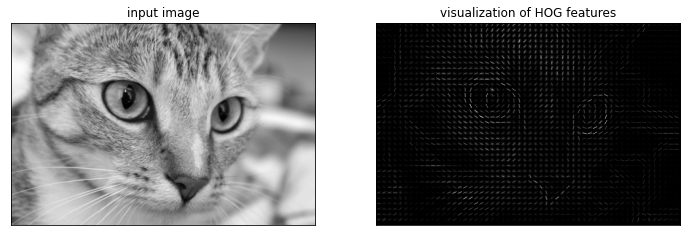

In [14]:
from skimage import data, color, feature, exposure
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, orientations=9)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_vis, in_range=(0, 10))
ax[1].imshow(hog_image_rescaled, cmap='gray')
ax[1].set_title('visualization of HOG features');

### Conjunto de amostras de treinamento positivas

Vamos começar encontrando alguns exemplos positivos de treinamento que mostram uma variedade de rostos.

Temos o conjunto de dados Labeled Faces in the Wild:

In [15]:
# from sklearn.datasets import fetch_lfw_people
# faces = fetch_lfw_people(min_faces_per_person=60)

positive_patches = faces.images
positive_patches.shape

(1348, 62, 47)

### Conjunto de amostras de treinamento negativas

Precisamos de um conjunto de imagens de tamanhos semelhantes que *não* sejam rostos.

Uma maneira de fazer isso é pegar qualquer corpus de imagens.

Aqui podemos usar algumas das imagens do Scikit-Image junto com o ``PatchExtractor`` do Scikit-Learn:

In [16]:
from skimage import transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
               
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

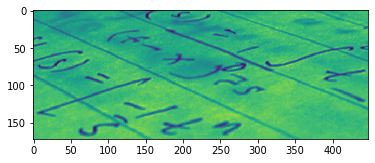

In [17]:
plt.imshow(images[1])

In [18]:
positive_patches[0].shape

(62, 47)

In [19]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):

    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = []
for im in images:
    for scale in [0.5, 1.0, 2.0]:
        negative_patches.append(extract_patches(im, 400, scale))

negative_patches = np.asarray(negative_patches)
i, r, m, n = negative_patches.shape
negative_patches = negative_patches.reshape(i*r,m,n)
negative_patches.shape


(12000, 62, 47)

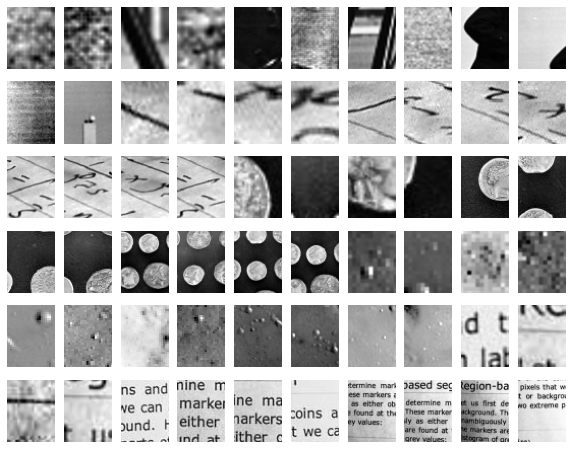

In [20]:
fig, ax = plt.subplots(6, 10, figsize=(10,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[100 * i], cmap='gray')
    axi.axis('off')

Nossa esperança é que estas amostras cubram suficientemente o espaço de "não faces" que nosso algoritmo provavelmente verá.

In [21]:
X_data = []

for im in positive_patches:
    X_data.append(feature.hog(im))

for im in negative_patches:
    X_data.append(feature.hog(im))

X_data = np.array(X_data)
X_data.shape

(13348, 1215)

In [22]:
y_data = np.zeros(X_data.shape[0])
y_data[:positive_patches.shape[0]] = 1

In [ ]:
y_data

array([1., 1., 1., ..., 0., 0., 0.])

### Treinamento de um SVM binário

Para uma tarefa de classificação binária de alta dimensão, uma máquina de vetores de suporte linear é uma boa escolha.

Usaremos o ``LinearSVC`` porque em comparação com o ``SVC`` ele geralmente tem melhor escalonamento para um grande número de amostras.

Primeiro, porém, vamos usar um Bayes ingênuo gaussiano simples para obter uma linha de base rápida:

In [23]:
from sklearn.svm import LinearSVC
# from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC( max_iter=10000, tol=0.001)
# podemos evitar a calibração
# clf = CalibratedClassifierCV(svc) ## para obter as probabilidades de cada classe
# print(clf.get_params().keys())
# grid = GridSearchCV(clf, {'base_estimator__C': [0.5, 1.0, 1.5]})

grid = GridSearchCV(svc, {'C': [0.5, 1.0, 1.5]})

grid.fit(X_data, y_data)

print(grid.best_score_)
print(grid.best_estimator_)

0.9947557404125323
LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)


In [24]:
model_face_detection = grid.best_estimator_

model_face_detection.fit(X_data, y_data)

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)

In [ ]:
# y_proba = model_face_detection.predict_proba(X_data)

In [ ]:
# y_proba

## Imagem de teste da internet

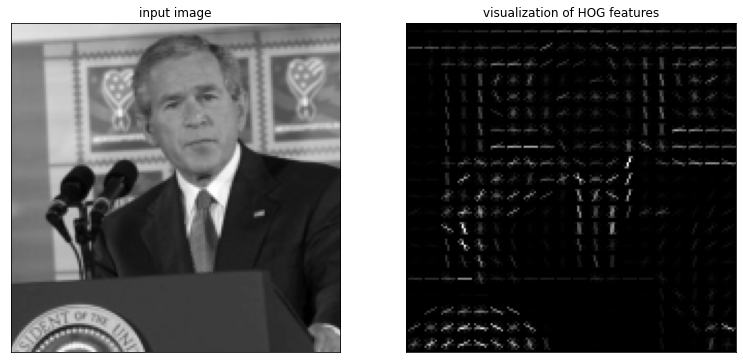

In [25]:
from skimage import io

test_im = io.imread("https://s3.static.brasilescola.uol.com.br/be/2021/06/ex-presidente-dos-eua-george-w-bush-falando-a-microfones-no-pulpito-presidencial.jpg")
test_im = color.rgb2gray(test_im)
test_im = skimage.transform.rescale(test_im, 0.5)
test_im = test_im[:160, 40:200]

test_hog_vec, test_hog_vis = feature.hog(test_im, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(13, 8), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(test_im, cmap='gray')
ax[0].set_title('input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(test_hog_vis, in_range=(0, 10))
ax[1].imshow(hog_image_rescaled, cmap='gray')
ax[1].set_title('visualization of HOG features');

In [26]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    indices = []
    sub_figures = []

    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            indices.append((i, j))
            sub_figures.append(patch)
    return indices, sub_figures

indices, patches = sliding_window(test_im)
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2401, 1215)

Finalmente, podemos pegar esses **patches** com atributos HOG e usar nosso modelo para avaliar se cada patch contém um rosto:

In [27]:
labels = model_face_detection.predict(patches_hog)
labels.sum()

12.0

Vemos que de quase 2400 patches, encontramos 12 detecções. 

Vamos usar as informações que temos sobre esses patches para mostrar onde eles estão em nossa imagem de teste, desenhando-os como retângulos:

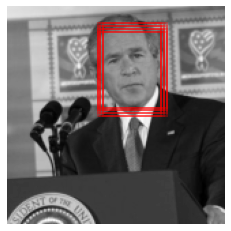

In [28]:
fig, ax = plt.subplots()
ax.imshow(test_im, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

Todas as detecçõpes se sobrepõem e encontraram o rosto na imagem!

Nada mal para algumas linhas de Python.

Agora dois caminhos são possíveis para obter a detecção final:

1. Passar cada patche pelo modelo SVM de reconhecimento

2. Escolher a detecção com maior probabilidade e passar pelo reconhecimento

Vamos seguir a primeira abordagem, mesmo que seja computacionalmente mais intensiva:


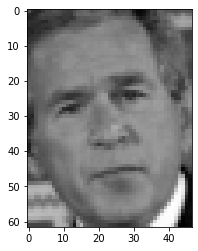

In [29]:
detections = []

Ni, Nj = positive_patches[0].shape

for i, j in indices[labels == 1]:
    detections.append(test_im[i:i+Ni, j:j+Nj] )

detections = np.array(detections)

plt.imshow(detections[0], cmap='gray');

In [30]:
detections.shape

(12, 62, 47)

In [31]:
final_preds = model_best.predict(detections.reshape(detections.shape[0], 62*47))

faces.target_names[final_preds]

array(['George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush'],
      dtype='<U17')

Existem várias melhorias que poderiam ser feitas. Em particular:

### Nosso conjunto de treinamento, especialmente para características negativas, não é muito completo

O problema central é que existem muitas texturas semelhantes a rostos que não estão no conjunto de treinamento e, portanto, nosso modelo atual é muito sujeito a falsos positivos.

Podemos imaginar lidar com isso adicionando uma variedade maior de imagens ao conjunto de treinamento negativo, e isso provavelmente resultaria em alguma melhoria.

Outra maneira de resolver isso é usar uma abordagem mais direcionada, como **hard negative mining**.

Nesse caso, pegamos um novo conjunto de imagens que nosso classificador não viu, encontramos todos os patches que representam falsos positivos e os adicionamos explicitamente como instâncias negativas no conjunto de treinamento antes de treinar novamente o classificador.

### Nosso pipeline atual detecta apenas em uma escala

Conforme escrito atualmente, nosso algoritmo perderá faces que não têm aproximadamente 62 × 47 pixels.

Isso pode ser resolvido diretamente usando janelas deslizantes de vários tamanhos e redimensionando cada patch usando ``skimage.transform.resize`` antes da detecção.

### Devemos combinar patches de detecção sobrepostos

Para um pipeline pronto para produção, preferiríamos evitar 12 detecções da mesma face, mas de alguma forma reduzir grupos sobrepostos de detecções a uma única detecção.

Isso poderia ser feito por meio de uma abordagem utilizando o **non-maximum suppression**, um algoritmo comum em visão computacional.

### Avanços mais recentes: Deep Learning

Finalmente, devo acrescentar que HOG e outros métodos de extração de recursos procedimentais para imagens não são mais técnicas de última geração.

Em vez disso, muitos pipelines modernos de detecção de objetos usam variantes de redes neurais profundas: uma maneira de pensar em redes neurais é que elas são um estimador que determina estratégias de extração de atributos ideais dos dados, em vez de depender da intuição do usuário.

# A atividade prática para enviar começa aqui!

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns

In [33]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person = 60)

print(faces.target_names)
print(faces.target)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
[1 3 3 ... 7 3 5]
(1348, 62, 47)


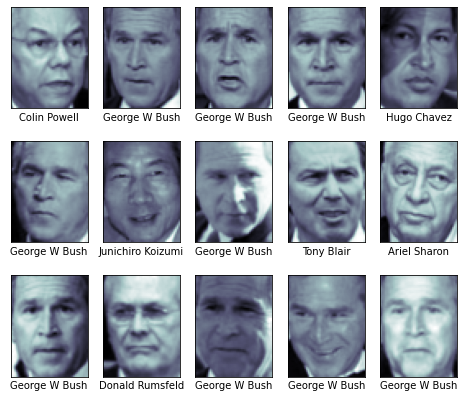

In [34]:
fig, ax = plt.subplots(3, 5,figsize=(8,7))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [35]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components = 150, whiten='True', random_state=42)

svc = SVC(kernel='rbf')

model = make_pipeline(pca, svc)

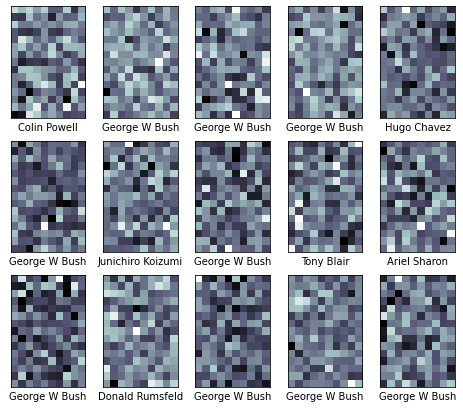

In [36]:
X_pca = pca.fit_transform(faces.data)

X_pca = X_pca.reshape(1348, 15, 10)

fig, ax = plt.subplots(3, 5,figsize=(8,7))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_pca[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])


In [37]:

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

from sklearn.model_selection import GridSearchCV

# fine tuning

# param_grid = {'svc__C': [1, 5, 10, 50],
#               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}


param_grid = {'svc__C': [9.8, 10, 10.2],
              'svc__gamma': [0.0009, 0.001, 0.0011]}


grid = GridSearchCV(model, param_grid, cv=5)

%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: user 36.4 s, sys: 21.3 s, total: 57.7 s
Wall time: 33.4 s
{'svc__C': 10.2, 'svc__gamma': 0.0009}


In [38]:
model_best = grid.best_estimator_
print(model_best)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=150,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten='True')),
                ('svc',
                 SVC(C=10.2, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.0009,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [39]:
y_pred = model_best.predict(Xtest)

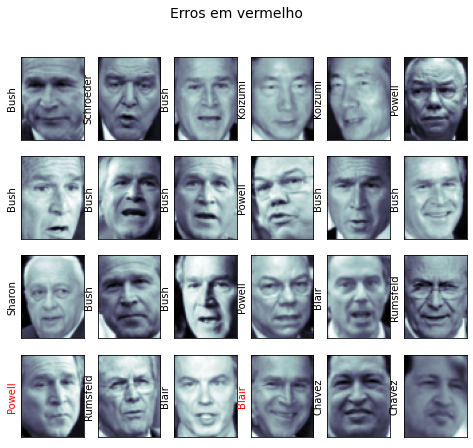

In [40]:
fig, ax = plt.subplots(4, 6, figsize=(8,7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == ytest[i] else 'red')
    
fig.suptitle('Erros em vermelho', size=14);

In [41]:
from sklearn.metrics import classification_report

print(classification_report(ytest, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.67      0.69        15
     Colin Powell       0.81      0.87      0.84        68
  Donald Rumsfeld       0.82      0.74      0.78        31
    George W Bush       0.88      0.87      0.88       126
Gerhard Schroeder       0.75      0.78      0.77        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      0.92      0.92        12
       Tony Blair       0.87      0.95      0.91        42

         accuracy                           0.85       337
        macro avg       0.84      0.81      0.82       337
     weighted avg       0.85      0.85      0.84       337



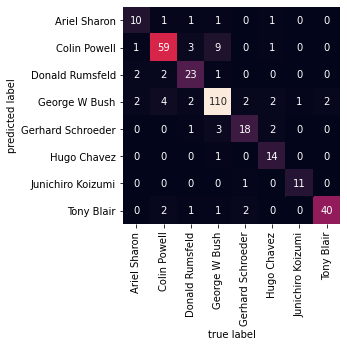

In [42]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_pred)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

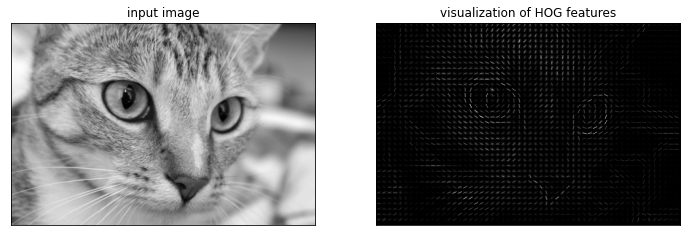

In [43]:
from skimage import data, color, feature, exposure
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, orientations=9)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_vis, in_range=(0, 10))
ax[1].imshow(hog_image_rescaled, cmap='gray')
ax[1].set_title('visualization of HOG features');

In [44]:
positive_patches = faces.images
positive_patches.shape


(1348, 62, 47)

In [45]:
from skimage import transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
               
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

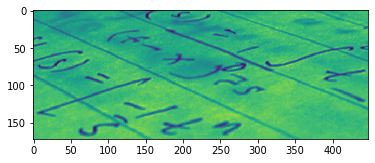

In [46]:
plt.imshow(images[1])

In [47]:
positive_patches[0].shape


(62, 47)

In [48]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):

    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = []
for im in images:
    for scale in [0.5, 1.0, 2.0]:
        negative_patches.append(extract_patches(im, 400, scale))

negative_patches = np.asarray(negative_patches)
i, r, m, n = negative_patches.shape
negative_patches = negative_patches.reshape(i*r,m,n)
negative_patches.shape

(12000, 62, 47)

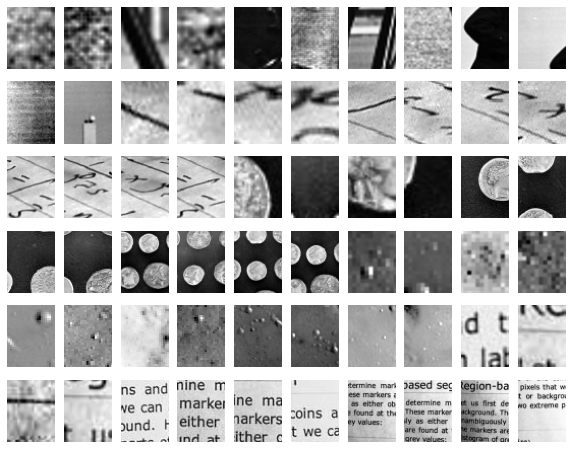

In [49]:
fig, ax = plt.subplots(6, 10, figsize=(10,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[100 * i], cmap='gray')
    axi.axis('off')

In [50]:
X_data = []

for im in positive_patches:
    X_data.append(feature.hog(im))

for im in negative_patches:
    X_data.append(feature.hog(im))

X_data = np.array(X_data)
X_data.shape


(13348, 1215)

In [51]:
y_data = np.zeros(X_data.shape[0])
y_data[:positive_patches.shape[0]] = 1    

y_data

array([1., 1., 1., ..., 0., 0., 0.])

In [52]:
from sklearn.svm import LinearSVC
# from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC( max_iter=10000, tol=0.001)
# podemos evitar a calibração
# clf = CalibratedClassifierCV(svc) ## para obter as probabilidades de cada classe
# print(clf.get_params().keys())
# grid = GridSearchCV(clf, {'base_estimator__C': [0.5, 1.0, 1.5]})

grid = GridSearchCV(svc, {'C': [0.5, 1.0, 1.5]})

grid.fit(X_data, y_data)

print(grid.best_score_)
print(grid.best_estimator_)

0.9947557404125323
LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)


In [53]:
model_face_detection = grid.best_estimator_

model_face_detection.fit(X_data, y_data)

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)

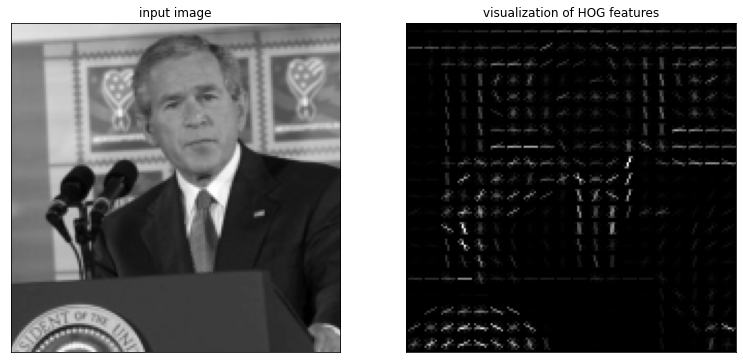

In [54]:
from skimage import io

test_im = io.imread("https://s3.static.brasilescola.uol.com.br/be/2021/06/ex-presidente-dos-eua-george-w-bush-falando-a-microfones-no-pulpito-presidencial.jpg")
test_im = color.rgb2gray(test_im)
test_im = skimage.transform.rescale(test_im, 0.5)
test_im = test_im[:160, 40:200]

test_hog_vec, test_hog_vis = feature.hog(test_im, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(13, 8), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(test_im, cmap='gray')
ax[0].set_title('input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(test_hog_vis, in_range=(0, 10))
ax[1].imshow(hog_image_rescaled, cmap='gray')
ax[1].set_title('visualization of HOG features');

In [55]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    indices = []
    sub_figures = []

    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            indices.append((i, j))
            sub_figures.append(patch)
    return indices, sub_figures

indices, patches = sliding_window(test_im)
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2401, 1215)

In [56]:
labels = model_face_detection.predict(patches_hog)
labels.sum()


12.0

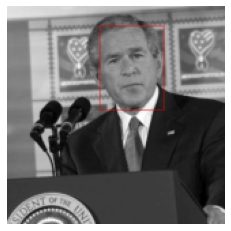

In [57]:
fig, ax = plt.subplots()
ax.imshow(test_im, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

scores = model_face_detection.decision_function(patches_hog)

for i, j in indices[scores == scores.max()]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

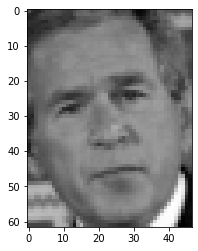

In [58]:
detections = []

Ni, Nj = positive_patches[0].shape

for i, j in indices[labels == 1]:
    detections.append(test_im[i:i+Ni, j:j+Nj] )

detections = np.array(detections)

plt.imshow(detections[0], cmap='gray');

In [59]:
final_preds = model_best.predict(detections.reshape(detections.shape[0], 62*47))

faces.target_names[final_preds]

array(['George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush'],
      dtype='<U17')